# **Tech Challenge 2 - Previsão Ibovespa**

# **1. Importações**

In [46]:
# Manipulação de dados
import polars as pl
import pandas as pd
import numpy as np

# Banco de dados
import sqlalchemy as db

# Visualização
import matplotlib.pyplot as plt

# Prophet
from prophet import Prophet

# Configurações
plt.style.use("seaborn-v0_8")

from sklearn.metrics import accuracy_score


## **2. Carregamento dos Dados (CSV)**

Arquivo extraído do Investing.com com dados diários do Ibovespa.

Datas extraídas:
**01.01.2024 - 01.12.2025**

In [4]:
path = "data/dados_ibovespa.csv"

df_raw = pd.read_csv(path)
df_raw.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,01.12.2025,158.611,159.073,159.224,158.029,"7,50B","-0,29%"
1,28.11.2025,159.072,158.358,159.689,158.078,"8,02B","0,45%"
2,27.11.2025,158.360,158.554,158.864,158.167,"4,47B","-0,12%"
3,26.11.2025,158.555,155.915,158.714,155.914,"8,60B","1,70%"
4,25.11.2025,155.910,155.278,156.373,154.821,"6,93B","0,41%"


# **3. Pré-Processamento dos Dados**

Padronização dos nomes das colunas

O arquivo do Investing vem com acentos e espaços, o que precisa ser ajustado.

In [24]:
df = df_raw.rename(columns={
    "Data": "ds",
    "Último": "close",
    "Abertura": "open",
    "Máxima": "high",
    "Mínima": "low",
    "Vol.": "volume",
    "Var%": "variation"
})

## **4. Conversão de tipos**

### **4.1 Datas**

In [ ]:
# Converter datas
df["ds"] = pd.to_datetime(
    df["ds"],
    format="%d.%m.%Y"
)

### 4.2 Colunas de preco

In [ ]:
# Colunas numéricas
price_cols = ["close", "open", "high", "low"]

for col in price_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(".", "", regex=False)
        .str.replace(",", ".", regex=False)
        .astype(float)
    )

### **4.3 Volume**

Convertendo a coluna e tratando valores nulos

In [26]:
def parse_volume(v):
    """
    Converte a coluna de volume para formato numérico absoluto.

    O volume pode vir em diferentes escalas:
    - K: milhares
    - M: milhões
    - B: bilhões

    Também trata valores ausentes ou inválidos.
    """

    # Verifica valores nulos, vazios ou representados por "-"
    if pd.isna(v) or v in ["-", ""]:
        return np.nan

    # Converte para string, remove espaços extras e padroniza para maiúsculas
    v = str(v).strip().upper()

    # Converte vírgula decimal para ponto
    v = v.replace(".", "").replace(",", ".")

    # Se o volume estiver em bilhões (B)
    if v.endswith("B"):
        return float(v.replace("B", "")) * 1_000_000_000

    # Se o volume estiver em milhões (M)
    if v.endswith("M"):
        return float(v.replace("M", "")) * 1_000_000

    # Se o volume estiver em milhares (K)
    if v.endswith("K"):
        return float(v.replace("K", "")) * 1_000

    # Caso o valor já esteja em formato numérico simples
    return float(v)


## **4.4 Variação**

Tratando coluna Variação

In [27]:
df["variation"] = (
    df["variation"]
    .str.replace("%", "", regex=False)
    .str.replace(",", ".", regex=False)
    .astype(float)
)

## **5. Ordenação Temporal e Limpeza**

Removendo dias faltantes (Ibovespa não funciona nos finais de semana e feriados)


In [28]:
df = df.sort_values("ds").reset_index(drop=True)
df = df.dropna(subset=["close"])

df.head()

,ds,close,open,high,low,volume,variation
0,2023-01-02,106376.0,109734.0,109734.0,105981.0,"8,13M",-3.06
1,2023-01-03,104166.0,106377.0,106684.0,103852.0,"14,47M",-2.08
2,2023-01-04,105334.0,104167.0,105627.0,103915.0,"14,45M",1.12
3,2023-01-05,107641.0,105336.0,107743.0,105333.0,"15,51M",2.19
4,2023-01-06,108964.0,107642.0,109433.0,107642.0,"12,63M",1.23


## **6. Modelos de Treinamento**

## **6.1 Prophet**

Preparação para o Prophet

In [ ]:
df_prophet = df[["date", "close"]].rename(columns={
    "date": "ds",
    "close": "y"
})

df_prophet = df_prophet.sort_values("ds").reset_index(drop=True)


,ds,y
0,2023-01-02,106376.0
1,2023-01-03,104166.0
2,2023-01-04,105334.0
3,2023-01-05,107641.0
4,2023-01-06,108964.0


Separando os últimos 30 dias para teste

In [53]:
test_days = 30

train = df_prophet.iloc[:-test_days]
test = df_prophet.iloc[-test_days:]

Treinamento do modelo

In [54]:
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True
)

model.fit(train)

20:16:17 - cmdstanpy - INFO - Chain [1] start processing
20:16:17 - cmdstanpy - INFO - Chain [1] done processing


Previsão (apenas dias úteis)

Definindo a frequência de atualização como B (Business Days), pois o Ibovespa atualiza apenas nos dias úteis

In [56]:
future = model.make_future_dataframe(
    periods=test_days,
    freq="B"  # Business days (dias úteis)
)

forecast = model.predict(future)

Unindo Previsão com valores Reais

In [57]:
forecast_test = forecast[["ds", "yhat"]].iloc[-test_days:].reset_index(drop=True)
test = test.reset_index(drop=True)

test = pd.concat([test, forecast_test["yhat"]], axis=1)


Definindo a acurácia como Maior (>) ou Menor (<)

In [61]:
test["target"] = np.where(
    test["y"] > test["y"].shift(1),
    1,
    0
)

test["pred_direction"] = np.where(
    test["yhat"] > test["yhat"].shift(1),
    1,
    0
)

test = test.dropna(subset=["target", "pred_direction"]) # Removendo Nulos

Acurácia

In [64]:
accuracy = accuracy_score(
    test["target"].astype(int),
    test["pred_direction"].astype(int)
)

print(f"Acurácia direcional: {accuracy:.2%}")

if accuracy >= 0.75:
    print("Modelo aprovado (>= 75%)")
else:
    print("Modelo abaixo de 75%")

Acurácia direcional: 53.33%
Modelo abaixo de 75%


Visualização 

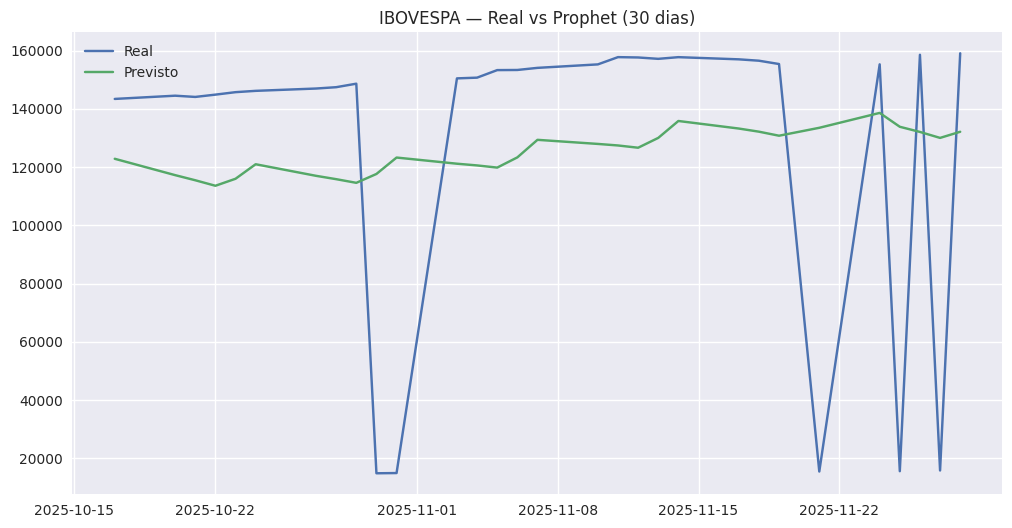

In [63]:
plt.figure(figsize=(12, 6))
plt.plot(test["ds"], test["y"], label="Real")
plt.plot(test["ds"], test["yhat"], label="Previsto")
plt.legend()
plt.title("IBOVESPA — Real vs Prophet (30 dias)")
plt.show()